# Automatic extraction of time series features 

In order to correlate the CNN model performance with the properties of the groundwater time series, different libraries are applied ( kats, tsfresh, tsfel and tsfeatures) to rapidly obtain different parameters that allow us to understand and interpret the modeled results. 


In [1]:
%matplotlib notebook
import pandas as pd
import geopandas as gpd
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from tsfeatures import tsfeatures
from tsfeatures import stability, series_length, flat_spots, stl_features,acf_features,pacf_features
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features
from pathlib import Path

In [2]:
path= "J:/NUTZER/GomezOspina.M/Paper_kidev/reviews/"
dfsw=pd.read_pickle(path+"//gwsinmodel2.pkl") #sin model simulation results 
gwdata=pd.read_pickle(path+"//gw_features.pkl")

## Extract features available in TSfeatures library

__Stability , lumpiness__: Stability and lumpiness are two time series features based on tiled (non-overlapping) windows. Means or variances are produced for all tiled windows. Then stability is the variance of the means, while lumpiness is the variance of the variances.

In [3]:
#List of available features
ltsfeatures=[ 'series_length', 'stability',  'flat_spots', 'x_acf1']
for i in ltsfeatures:
    gwdata[i]=np.nan

### Feature extraction per well

In [4]:
dfraw=gwdata['GW_NN'][0]
df=dfraw[[dfraw.columns[0],dfraw.columns[-1]]]
df["unique_id"]=[dfraw.columns[-1]]*len(df) 

In [5]:
cou=0
for dfraw in gwdata['GW_NN']:
    dfraw=gwdata['GW_NN'][0]
    df=dfraw[[dfraw.columns[0],dfraw.columns[-1]]]
    df["unique_id"]=[dfraw.columns[-1]]*len(df)  #give the unique code as the library requested it 
    
    #well id as an integer to search in the gw_sel file--> shapefile witht the well locations
    wellid=int(dfraw.columns[-1].split("_")[-1])
    cou+=1
    indv=gwdata[gwdata['wellid']==wellid].index[0]
    
    #Copy the dataframe to avoid modifications in the original one. 
    dfc=df.copy()
    dfc.rename(columns={dfraw.columns[0]: "ds", dfraw.columns[-1]: "y"}, inplace=True)
    serieslength=len(dfc)

    feat=tsfeatures(dfc, freq=30, features=[stability, flat_spots,acf_features])

    #print(feat)
    for c in ltsfeatures:
        
        gwdata.at[indv,c]=feat[c][0] 
    
    

Exception in thread Thread-5 (_handle_workers):
Traceback (most recent call last):
  File "d:\Data\CSA\conda\envs\mgopaper\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\Data\CSA\conda\envs\mgopaper\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Data\CSA\conda\envs\mgopaper\lib\multiprocessing\pool.py", line 522, in _handle_workers
    cls._wait_for_updates(current_sentinels, change_notifier)
  File "d:\Data\CSA\conda\envs\mgopaper\lib\multiprocessing\pool.py", line 502, in _wait_for_updates
    wait(sentinels, timeout=timeout)
  File "d:\Data\CSA\conda\envs\mgopaper\lib\multiprocessing\connection.py", line 879, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "d:\Data\CSA\conda\envs\mgopaper\lib\multiprocessing\connection.py", line 811, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of leng

## Extract features available in tsfresh library

__Sample entropy__: Approximate Entropy and Sample Entropy are two algorithms for determining the regularity of series of data based on the existence of patterns. (ncbi.nlm.nih.gov/pmc/articles/PMC7515030/) 

__cid_ce__: This function calculator is an estimate for a time series complexity [1] (A more complex time series has more peaks, valleys etc.). 

__autocorrelation__:Calculates the autocorrelation of the specified lag

__Partial correlation__: is a method used to describe the relationship between two variables whilst taking away the effects of another variable, or several other variables, on this relationship.

__number_of_peaks__: Calculates the number of peaks of at least support n in the time series x. A peak of support n is defined as a subsequence of x where a value occurs, which is bigger than its n neighbours to the left and to the right.

__Lempel–Ziv complexity__ : The Lempel-Ziv complexity (LZ) is a popular tool to quantify the uncertainty contained in time series data. In particular, LZ measures how “diverse” are the patterns that are present in a particular signal. (https://information-dynamics.github.io/complexity/information/2019/06/26/lempel-ziv.html)

__Matrix profile__ : The distance profile is a vector of minimum Z-Normalized Euclidean Distances.The profile index contains the index of its first nearest-neighbor. In other words, it is the location of its most similar sub-sequence. (https://towardsdatascience.com/introduction-to-matrix-profiles-5568f3375d90) 

In [19]:
#List of features with high-correlation according to previous checks
lfeatures=['y__longest_strike_below_mean','y__longest_strike_above_mean',
              'y__fourier_entropy__bins_3',
                'y__sample_entropy', 'y__cid_ce__normalize_True', 'y__autocorrelation__lag_6', 
               'y__lempel_ziv_complexity__bins_3','y__partial_autocorrelation__lag_3', 
               'y__number_peaks__n_10', 'y__approximate_entropy__m_2__r_0.5']

In [50]:

for dfraw in gwdata['GW_NN']:
    df=dfraw[[dfraw.columns[0],dfraw.columns[-1]]]
    df["id"]=[dfraw.columns[-1]]*len(df)  #give the unique code as the library requested it 
    
    #well id as an integer to search in the gw_sel file--> shapefile witht the well locations
    wellid=int(dfraw.columns[-1].split("_")[-1])
    indv=gwdata[gwdata['wellid']==wellid].index[0]
    
    #Copy the dataframe to avoid modifications in the original one. 
    dfc=df.copy()
    dfc.rename(columns={dfraw.columns[0]: "time", dfraw.columns[-1]: "y"}, inplace=True)
    feat=extract_features(dfc, column_id="id", column_sort="time")
    
    for c in lfeatures:
        gwdata.at[indv,c]=feat[c][0] 

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


### Fourier Power Spectrum 

In [ ]:
gwdata['ffpower']=np.nan

for wl in range(len(gwdata)):
        
    ts = gwdata.GW_NN[wl][gwdata.GW_NN[wl].columns[-1]]
    # Compute the FFT
    fft_result = np.fft.fft(ts.values)
    fft_freq = np.fft.fftfreq(len(ts), d=1)

    # Keep only positive frequencies (since FFT is symmetric)
    positive_freq_mask = fft_freq > 0
    fft_result = fft_result[positive_freq_mask]
    fft_freq = fft_freq[positive_freq_mask]

    # Compute the power spectrum
    power_spectrum = np.abs(fft_result)**2
    index_one_year = np.argmin(np.abs(fft_freq - 1/12)) # power of the spectrum at one year
    gwdata['ffpower'][wl] =  power_spectrum[index_one_year]

## Extract Pearson/Spearmann coefficient

In [54]:
#Join list of features
ltsfeatures=[ 'series_length', 'stability', 'trend', 
             'seasonal_strength', 'flat_spots', 'seas_acf1']
lfeatures=['y__longest_strike_below_mean','y__longest_strike_above_mean',
              'y__fourier_entropy__bins_3',
                'y__sample_entropy',  'y__autocorrelation__lag_6', 
               'y__lempel_ziv_complexity__bins_3','y__partial_autocorrelation__lag_3', 
               'y__number_peaks__n_10', 'y__approximate_entropy__m_2__r_0.5']
all_features=ltsfeatures+lfeatures+['ffpower']
gwdata[all_features]

,series_length,stability,trend,seasonal_strength,flat_spots,seas_acf1,y__longest_strike_below_mean,y__longest_strike_above_mean,y__fourier_entropy__bins_3,y__sample_entropy,y__autocorrelation__lag_6,y__lempel_ziv_complexity__bins_3,y__partial_autocorrelation__lag_3,y__number_peaks__n_10,y__approximate_entropy__m_2__r_0.5
0,592.0,0.082573,0.134237,0.087312,6.0,-0.437108,11.0,15.0,0.079983,1.469238,-0.372559,0.189189,-0.241762,26.0,0.838546
1,476.0,0.059715,0.071331,0.103283,9.0,-0.535319,17.0,16.0,0.079983,1.710678,-0.508121,0.220588,-0.228476,20.0,0.979764
2,379.0,0.098787,0.290659,0.117548,7.0,-0.374308,20.0,18.0,0.183378,1.317955,-0.092880,0.203166,-0.133828,17.0,0.708506
3,573.0,0.121807,0.211958,0.113806,8.0,-0.393054,9.0,11.0,0.125256,1.303873,-0.272862,0.188482,-0.297885,23.0,0.766135
4,598.0,0.169460,0.219871,0.081691,7.0,-0.417612,22.0,19.0,0.090729,1.494476,-0.272368,0.187291,-0.140223,32.0,0.789043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,278.0,0.106293,0.110449,0.149600,6.0,-0.479030,9.0,9.0,0.090729,1.210662,-0.464895,0.230216,-0.218563,15.0,0.804259
501,256.0,0.133299,0.215428,0.314928,5.0,-0.213675,10.0,19.0,0.125256,0.830880,-0.288653,0.238281,-0.257583,13.0,0.551084
502,256.0,0.188779,0.308242,0.409320,4.0,-0.080863,18.0,19.0,0.155665,0.690597,-0.128197,0.230469,-0.016490,9.0,0.501710
503,564.0,0.418150,0.687198,0.132386,11.0,-0.117699,91.0,70.0,0.247940,0.613914,0.530416,0.138298,0.076496,19.0,0.376934


In [55]:
def bootstrap(nsamp,gw):
    vindex=[]
    for k in range(nsamp): 
        index=np.random.randint(0,len(gw), len(gw))
        vindex.append(index)
    return vindex

In [91]:
#_2 means only using P and T as input variables 
perfor=[ 'r2_2', 'NSE_2', 'bias']

#Create dataframe to store the correlations
lzero=np.zeros(len(all_features))
d = {'variable': all_features,'r2_2':lzero, 'NSE_2':lzero, 'bias': lzero}
dfrval = pd.DataFrame(data=d)
#gw_sel_intc=gw_sel_int.copy()

for p in perfor:
    lrvalue = []
    
    vindex=bootstrap(1000, gwdata[p])
    
    for col in all_features:
        vlrvalue= []
        for i in vindex:
            slope, intercept, r_value, p_value, std_err = stats.linregress(gwdata[col][i], 
                                                                           gwdata[p][i])
            vlrvalue.append(round(r_value,2)) if p_value <= 0.1 else vlrvalue.append(0) 
            
        # add only the correlations that are statistically significant
        lrvalue.append(round(np.nanmean(vlrvalue),2)) 
                         
    dfrval[p]=lrvalue
    
dfrvalcc=dfrval.copy()
dfrvalcc.rename(columns={"r2_2":"r$^2$","NSE_2":"NSE", "bias":"BIAS"}, inplace=True)

In [93]:
dictionary={
            'series_length': 'Series length', 
            'stability': 'Stability',
            'trend':  'Seasonal trend', 
            'seasonal_strength':'Seasonal strength', 
            'flat_spots': 'Flat spots',  
            'x_acf10': 'Sum of squares of autocorrelation coefficients', 
            'seas_acf1': 'Seasonal autocorrelation', 
            'y__longest_strike_below_mean': 'Longest strike below mean',
            'y__longest_strike_above_mean': 'Longest strike above mean',
            'y__fourier_entropy__bins_3': 'Fourier entropy',
            'y__sample_entropy': 'Sample entropy', 
            'y__autocorrelation__lag_6':'Autocorrelation', 
            'y__lempel_ziv_complexity__bins_3': 'Lempel ziv complexity',
            'y__partial_autocorrelation__lag_3':'Partial autocorrelation', 
            'y__number_peaks__n_10': 'Number of peaks',
            'y__approximate_entropy__m_2__r_0.5': 'Approximate entropy', 
            'ffpower':'Fourier power spectral density'
}


dfrvalcc["variables_d"]=dfrvalcc['variable'].map(dictionary)

labels=['Autocorrelation',  'Stability', 'Flat spots', 
       'Longest strike below mean', 
       'Longest strike above mean', 'Series length', 
       'Approximate entropy',  
       'Number of peaks', 'Fourier power spectral density']

In [107]:
dfrvalccf1=dfrvalcc.sort_values(by="order")
dfrvalccf2=dfrvalccf1.set_index('variables_d')
dfrvalccf=dfrvalccf2[dfrvalccf2.columns[1:-1]]

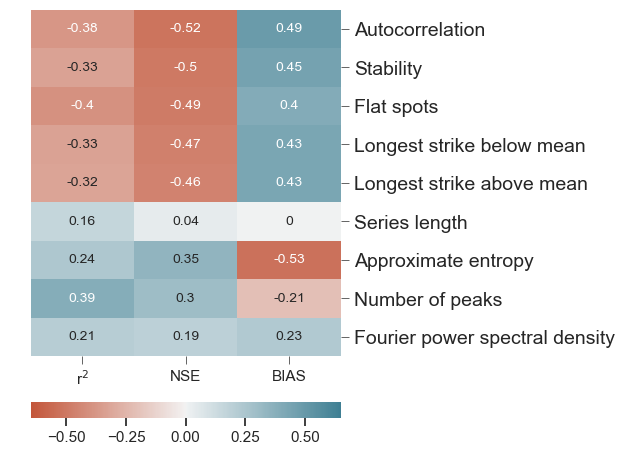

In [70]:
%matplotlib inline


fig = plt.figure(figsize=(6,10))
cmap = sns.diverging_palette(20, 220, as_cmap=True)
ax= sns.heatmap(dfval, annot=True,cmap=cmap, center=0,  annot_kws={"size":10}, vmin=-.65, vmax=.65, 
                cbar=False)
ax.tick_params(axis='y', left=False, right=True, bottom=True, labelright=True, labelleft =False, labelrotation=0,
              labelsize=14, width=0.5)
ax.tick_params(axis='x', bottom=True,width=0.5)
#plt.legend(loc='lower center')
cbar = ax.figure.colorbar(ax.collections[0], orientation='horizontal', pad=0.1)
cbar.outline.set_visible(False)
fig.set_size_inches(4, 6)
plt.ylabel(' ')

plt.savefig(path+'matrixts2.pdf', bbox_inches='tight', facecolor="white")